In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
import seaborn as sns
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.feature_selection import chi2
from scipy import stats
from copy import copy

In [2]:
df = pd.read_csv("../input/adult-pmr3508/train_data.csv", sep=r'\s*,\s*', engine='python', na_values="?")
df['income'] = df['income'].map({"<=50K": 0, ">50K": 1})

# Data Pre-processing

#### 1. Data Normalization
    Checking if the numerical features of the dataset have similar scales

In [3]:
display(df.describe().loc[['mean', 'min', 'max']])

,Id,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week,income
mean,32559.5,38.581634,1.897818e+05,10.08059,1077.615172,87.306511,40.437469,0.240817
min,16280.0,17.000000,1.228500e+04,1.00000,0.000000,0.000000,1.000000,0.000000
max,48839.0,90.000000,1.484705e+06,16.00000,99999.000000,4356.000000,99.000000,1.000000


#### Average Scale of the Numerical Features:
* **Age, Education-Num, Capital Loss** and **Hours per Week** : $10^{0}$
* **fnlwgt**: $10^{5}$
* **Capital Gain**: $10^{3}$

        As the numerical features have different scales, they will be normalized. This is done because the *K-nearest-neighbors algorithms is very sensitive to features with high scales,as these will have a higher impact in the distance calculus. Normalizing the data is import to garantee that all numerical features have a similar impact in the distances calculated in the KNN algorithm.

#### 1.1 Choosing the normalization method
##### 1.1.1 Detecting outliers
    Detecting outliers in the dataset is an important step before deciding which normalization method will be used because some of them are very sensitive to this type of data observation.

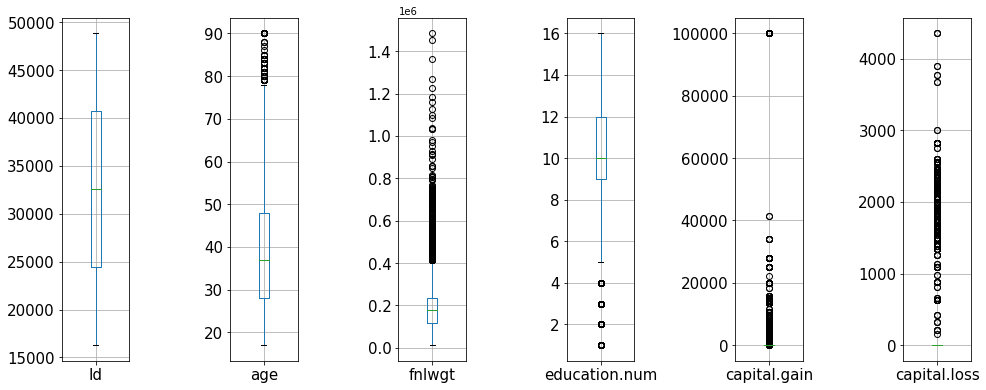

In [4]:
fig, axes = plt.subplots(nrows = 1, ncols = 6, figsize=(15, 7))
fig.tight_layout(pad=7.0)
num_ftrs_slc = selector(dtype_exclude = object)
num_ftrs = num_ftrs_slc(df)
for i, bp in enumerate(axes.flat):
    df.boxplot(column = num_ftrs[i], ax = bp, fontsize=15)

##### Calculating the number of Outliers using the  Interquartile Range (IQR) 
<br>
  As noticed above, using the Boxplot Method to detect outliers with respect to all the numerical features  leads to the conclusion that all of them have outliers - the black points outside the blue boxes.
The BoxPlot uses the Interquartile Range (IQR) criteria to define which data points should be represented as outliers (black points)
  
***
$\mathbf{\text{Interquartile Range Criteria}}$<br>
***
1.*&emsp;For each **data_point** verify for each of its **features** if* $$Q1(feature) - 1.5 IQR \leq data\_point[feature] \leq Q3(feature) + 1.5IQR$$
$$Q1\textrm{: first quartile}$$
$$Q3\textrm{: third quartile}$$
$$IRQ = Q3(feature) - Q1(feature)$$
2. *If not for some feature, the **data_point** is classified as an **outlier** with respect to that **feature**.*

In [5]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print("Percentage of Outliers \n",((df[num_ftrs] < (Q1 - 1.5 * IQR)) | 
                                     (df[num_ftrs] > (Q3 + 1.5 * IQR))).sum()*100/df.shape[0])

Percentage of Outliers 
 Id                 0.000000
age                0.439189
fnlwgt             3.046683
education.num      3.679361
capital.gain       8.326167
capital.loss       4.665233
hours.per.week    27.665848
income            24.081695
dtype: float64


As seen above, only the 'Age' feature has a negligible number of outliers. This way, a normalization method that is not outlier-sensible will be chosen to all numerical features.
***
Chosen Normalization Method: **Robust Scaling**
1.*&emsp;For each data_point $i$ having feature $x$ the  new normalized value $norm(x_i)$ is such that:
$$norm(x_i) = \frac{x_i - Q_2(x)}{Q_3(x) - Q_1(x)}$$
***

#### 2. Data Transformation

##### 2.1 Choosing the Appropriate Transformations

To choose the appropriate method to turn the categorical features into numbers we first need to understand which features have values with a natural order and which do not. Features without natural order will be transformed using **One Hot Encoding** and the others will be transformed with **Ordinal Encoding**

##### 2.1.1 Features Transformed with Ordinal Encoding
The categorical feature that seem to have a natural order is **Education**, and it is probably highly correlated to the numerical feature **Education-Num**.This correlation will be checked and treate later. Below the values this feature assume are shown.

In [6]:
print("Education feature assume the values",df['education'].unique())

Education feature assume the values ['Some-college' '10th' 'HS-grad' 'Bachelors' 'Assoc-acdm' '5th-6th'
 'Masters' '12th' 'Prof-school' 'Doctorate' '9th' '1st-4th' '7th-8th'
 'Assoc-voc' '11th' 'Preschool']


Only **Education** seems to have an ordering, which is defined below.

In [7]:
edc_order = ['Preschool', '1st-4th','5th-6th','7th-8th',
            '9th', '10th', '11th', '12th', 'HS-grad',
            'Some-college','Assoc-voc', 'Assoc-acdm',
            'Bachelors', 'Masters','Prof-school', 'Doctorate']

##### 2.1.2 Features Transformed with One Hot Encoding
* Martial Status
* Occupation
* Relationship
* Race
* Sex
* Country
* Workclass

##### 2.1.3 Features Transformed with Ordinal Encoding
* Education

In [8]:
ctgr_ftrs_slc = selector(dtype_include = object)
ctgr_ftrs = ctgr_ftrs_slc(df)

ohe_ftrs = ['marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country','workclass']
oe_ftrs = ['education']
total_new_ftrs = np.array([ n - 1 if n == 2 else n 
                           for i, n in enumerate([len(df[e].unique()) for e in ohe_ftrs])]).sum()
print(f"One Hot Encoding will add {total_new_ftrs - len(ohe_ftrs)} new columns to the dataframe")

ctgr_ohe_preproc = OneHotEncoder(handle_unknown = "ignore",dtype ='int', drop ="if_binary")
ctgr_oe_preproc = OrdinalEncoder( categories = [edc_order])
num_preproc = RobustScaler()

One Hot Encoding will add 78 new columns to the dataframe


##### 2.2 Robust Scaling and Ordinal Encoding

In [9]:
num_trans = num_preproc.fit_transform(df[num_ftrs].values)
oe_trans = ctgr_oe_preproc.fit_transform(df[oe_ftrs].values)
ftrs_trans = ((num_ftrs, num_trans), (oe_ftrs, oe_trans))

for cols, trans in ftrs_trans:
    for i, ftr in enumerate(cols):
        df[ftr] = pd.Series(trans[:,i])
        
num_ftrs.append('education')


##### 2.3 One Hot Encoding

In [10]:
ohe_trans = ctgr_ohe_preproc.fit_transform(df[ohe_ftrs].values).toarray()
new_ftrs_names = ctgr_ohe_preproc.get_feature_names_out(input_features = ohe_ftrs)
df_ohe_trans = pd.DataFrame(ohe_trans, columns = new_ftrs_names)    
df = df.drop(ohe_ftrs, axis = 1)
df = df.join(df_ohe_trans)

#### 3. Feature Selection

##### 3.1 Removing Features with low correlation with the Income Y variable
We will use two types of correlation analysis to see how each feature is related to the Income Y variable:
* **Chi-Square Test**: categorical/binary features
* **Point Biserial Correlation Coefficient**: used with continuous features. This is a special type of Pearson's Correlation Coefficient for when one variable is continuous and the other binary

In [11]:
def fill_corr_matrix(ftrs, corr_df, method, df, ftr_name = "", corr_name = ""):
    if method == 'pointbiserial':        
        for i in ftrs:
            coeff, p_val = stats.pointbiserialr(np.array(df[i]), np.array(df[ftr_name]))
            corr_df.loc[i,corr_name] = coeff    
    elif method == 'chi2':
        for i in ftrs:
            for j in ftrs:
                if i != j:
                    chi2_val, p_val = chi2(np.array(df[i]).reshape(-1, 1), np.array(df[j]).reshape(-1, 1))
                    corr_df.loc[i,j] = p_val
                                                
def drop_features(threshold, df, values_df): 
    true_false_df = (values_df > threshold)
    drop_ftrs = []
    for A in values_df.index.tolist():
        for B in values_df.index.tolist():
            if B in drop_ftrs or A in drop_ftrs or A == B:
                continue
            if values_df.at[B,A] > threshold:
                a_corr, b_corr = true_false_df[A].sum(), true_false_df[B].sum()
                D = A
                if a_corr < b_corr:
                    D = B            
                df = df.drop(D, axis = 1) 
                true_false_df = true_false_df.drop(D, axis = 0)
                true_false_df = true_false_df.drop(D, axis = 1)
                drop_ftrs.append(D)    
    return df

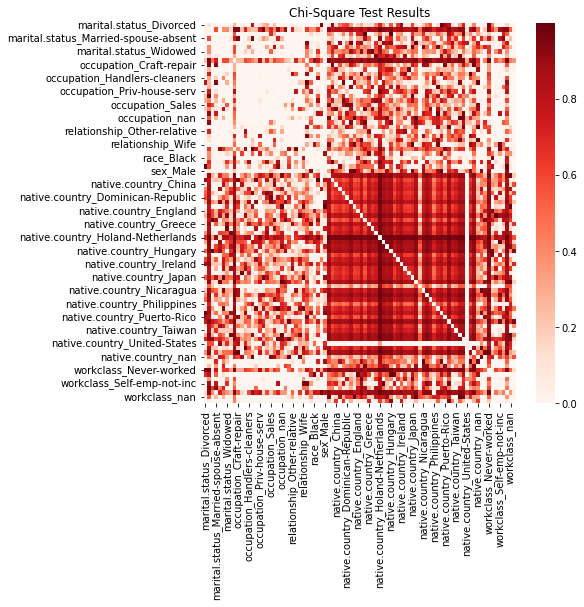

In [12]:
#Chi-Square Tests
ctgr_ftrs = copy(new_ftrs_names.tolist())
ctgr_ftrs.append('income')
p_values_df = pd.DataFrame(data=[(0 for i in range(len(ctgr_ftrs))) 
                                    for i in range(len(ctgr_ftrs))], 
                         columns = ctgr_ftrs)

p_values_df.set_index(pd.Index(ctgr_ftrs), inplace = True)
fill_corr_matrix(ctgr_ftrs, p_values_df,  'chi2', df)
           
fig = plt.figure(figsize=(7,7))
sns.heatmap(p_values_df, cmap = 'Reds')
plt.title('Chi-Square Test Results')
plt.show()

()The heatmap generated above illustrate the p-values of the Chi-Square Tests performed between every pair of binary variables in the dataframe. The diagonal line represents all the pairs of the same variable - all having $p-value = 0$. This was expected because the null hypothesis tested in such a test states that the two variables are independent. This way, we will use a thresholf of .05 to drop a feature.
<br>
1. &emsp;  For each binary feature check the p_value of the Chi-Square Test having the following Null Hypothesis:
***
$$H_0: \mathbf{\text{feature and Income Y are indepent}}$$
***
2. &emsp; If the p_value of the test is greater than 0.05, drop the feature.

In [13]:
p_val_threshold = 0.05
for ftr in new_ftrs_names:
    if p_values_df[ftr]['income'] > p_val_threshold:
        df = df.drop(ftr, axis = 1)
        p_values_df = p_values_df.drop(ftr, axis = 0)
        p_values_df = p_values_df.drop(ftr, axis = 1)

print(f"The dataframe has {df.shape[1]} columns after the Chi-Square Test with the Income")

The dataframe has 63 columns after the Chi-Square Test with the Income


##### 3.2 Removing Categorical Features with high correlation with other(s)  Categorical feature(s)
We will use the same correlation matrix generated on the previous session to analyze how each feature correlates to each other. We will use the following algorithm to determine which features to drop:

***
1. &emsp; Determine the two features associated with p_value larger than the threshold. Call them predictors A and B.
2. &emsp; Determine the number of features for which A has a p_value larger than the threshold. In other words, count the number of features that A is correlated with. Do the same for predictor B.
3. &emsp; If A is more correlated to other features than B, drop it; otherwise, drop B.
4. &emsp; Repeat Steps 1–3 until no p_value is above the threshold.
***

In [14]:
df = drop_features(p_val_threshold, df, p_values_df)
print(f"The dataframe has {df.shape[1]} columns after the Chi-Square Test between the binary variables")

The dataframe has 26 columns after the Chi-Square Test between the binary variables


##### 3.3 Removing Numerical Features with low correlation with the Income Y variable (Point Biserial Correlation Coefficient)


In [15]:
                                            
num_ftrs = np.intersect1d(np.array(df.columns.tolist()),
                            np.setdiff1d(np.array(num_ftrs),np.array(ctgr_ftrs))).tolist()
corr_df = pd.DataFrame(index = num_ftrs, columns = ['Corr w/ income'])       
fill_corr_matrix(num_ftrs, corr_df, 'pointbiserial', df, ftr_name = 'income', corr_name = 'Corr w/ income')                                        

corr_threshold = 0.2   
drop_cols = corr_df[ abs(corr_df['Corr w/ income']) < corr_threshold ].index.tolist()
df = df.drop(drop_cols, axis = 1)

##### 3.4 Removing Numerical Features highly correlated with each other

In [16]:
num_ftrs = np.intersect1d(np.array(df.columns.tolist()),
                            np.setdiff1d(np.array(num_ftrs),np.array(ctgr_ftrs))).tolist()

corr_threshold = 0.5
corr_coeff_df = df[num_ftrs].copy(deep = True).corr()
df = drop_features(corr_threshold, df, corr_coeff_df)

print(f"The dataframe has {df.shape[1]} columns after the Person's Coefficient Test between the numerical variables")

The dataframe has 22 columns after the Person's Coefficient Test between the numerical variables


##### 3.5 Removing Numerical Features highly correlated with Binary Features

In [17]:
num_ftrs = np.intersect1d(np.array(df.columns.tolist()),
                            np.setdiff1d(np.array(num_ftrs),np.array(ctgr_ftrs))).tolist()

ctgr_ftrs = np.setdiff1d(np.array(df.columns.tolist()), np.array(num_ftrs))
p_values_df = pd.DataFrame(index = num_ftrs, columns = ctgr_ftrs)
p_values_df.set_index(pd.Index(num_ftrs), inplace = True)

for i in ctgr_ftrs:
    fill_corr_matrix(num_ftrs, p_values_df, 'pointbiserial', df, ftr_name = i, corr_name = 'Corr w/ income')                                        

corr_threshold = 0.5
corr_ftrs = p_values_df[abs(p_values_df) > corr_threshold]

As noticed above, **Age** and **Martial Status_Never-married** have an absolute correlation coefficient greater than 50%. We will drop **Martial Status_Never-married**. 

#### 4 Dealing with the NAN values


In [18]:
null_tracker_ftrs = [s for s in df.columns.tolist() if 'nan' in s]
print(null_tracker_ftrs)

['occupation_nan', 'workclass_nan']


Above we see that only the features **Occupation** and **Workclass** had null values in the raw dataset. As both of these features were transformed with One-Hot Encoding, this means that all the generated features related to their transformations, for the rows where they were originally null, have no meaning. The only generated features that have some meaning are **Workclass_nan** and **Occupation_nan** for the null rows. In other words, the rows that had **Occupation** and **Workclass** with null in the raw dataset have **Workclass_nan** and **Occupation_nan** as 1 after one-hot-encoding. Let's check how many rows fall into these categories.

In [19]:
#As 'Occupation_nan' and 'Workclass_nan' are binary columns one can use sum() to get the total 1's

print(f"{df['occupation_nan'].sum()} rows had Occupation feature as null in the original dataset")
print(f"{df['workclass_nan'].sum()} rows had Workclass feature as null in the original dataset")
print(f"{df[(df['occupation_nan'] == 1) & (df['workclass_nan'] == 1)].shape[0]} rows had both features as null in the original dataset") 

1843 rows had Occupation feature as null in the original dataset
1836 rows had Workclass feature as null in the original dataset
1836 rows had both features as null in the original dataset


We notice that all rows that had **Workclass** null in the original dataset also had null in the **Occupation** feature. This way we can drop only the rows having **Occupation_nan == 1**.

In [20]:
df = df[df['occupation_nan'] != 1]
print(f"The dataframe has {df.shape[0]} rows after dropping the rows with null values")

The dataframe has 30717 rows after dropping the rows with null values


In [21]:
#Dropping the dummy variables created to track rows with null values
df = df.drop(null_tracker_ftrs, axis = 1)
print(f"{df.shape[1]} features were selected to train the KNN model!")

20 features were selected to train the KNN model!


# KNN Training

In [22]:
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.model_selection import KFold, cross_val_score
from sklearn.decomposition import PCA

In [23]:
def k_scores(first, last, x, y, splits, step = 1):
    max_scores = {}
    for k in range(first,last,step):
        KNN = knn(k)
        kfold = KFold(n_splits = splits)
        scores = cross_val_score(KNN, x, y, cv = kfold)
        score = np.amax(scores)
        max_scores[k] = score
    return max_scores

In [24]:
train_set = df.copy(deep = True)
y = train_set['income'].tolist()
train_set = train_set.drop('income', axis = 1)
x = train_set.values 

max_scores = k_scores(1,50, x, y, 10,step = 4)
n = max(max_scores, key = max_scores.get)
max_scores = k_scores(n - 6, n + 1, x, y, 10)
n = max(max_scores, key = max_scores.get)

print(f"The model will have {n} neighbors, and estimated accuracy of {max_scores[n]}")
model = knn(n_neighbors = n)
model.fit(x,y)


The model will have 29 neighbors, and estimated accuracy of 0.8606317160534028


KNeighborsClassifier(n_neighbors=29)

# KNN Testing

In [25]:
test_set = pd.read_csv("../input/adult-pmr3508/test_data.csv", sep=r'\s*,\s*', engine='python', na_values="?")

num_ftrs_slc = selector(dtype_exclude = object)
num_ftrs = num_ftrs_slc(test_set)
ctgr_ftrs_slc = selector(dtype_include = object)
ctgr_ftrs = ctgr_ftrs_slc(test_set)

ohe_ftrs = ['marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country','workclass']
oe_ftrs = ['education']
total_new_ftrs = np.array([ n - 1 if n == 2 else n 
                           for i, n in enumerate([len(test_set[e].unique()) for e in ohe_ftrs])]).sum()

ctgr_ohe_preproc = OneHotEncoder(handle_unknown = "ignore",dtype ='int', drop ="if_binary")
ctgr_oe_preproc = OrdinalEncoder( categories = [edc_order])
num_preproc = RobustScaler()

num_trans = num_preproc.fit_transform(test_set[num_ftrs].values)
oe_trans = ctgr_oe_preproc.fit_transform(test_set[oe_ftrs].values)
ftrs_trans = ((num_ftrs, num_trans), (oe_ftrs, oe_trans))

for cols, trans in ftrs_trans:
    for i, ftr in enumerate(cols):
        test_set[ftr] = pd.Series(trans[:,i])
        
num_ftrs.append('education')



ohe_trans = ctgr_ohe_preproc.fit_transform(test_set[ohe_ftrs].values).toarray()
new_ftrs_names = ctgr_ohe_preproc.get_feature_names_out(input_features = ohe_ftrs)
df_ohe_trans = pd.DataFrame(ohe_trans, columns = new_ftrs_names)    
test_set = test_set.drop(ohe_ftrs, axis = 1)
test_set = test_set.join(df_ohe_trans)

test_set = test_set[train_set.columns.tolist()]
test_set.dropna(inplace = True)

In [26]:
predicted = model.predict(test_set.values)
submission = pd.DataFrame(data = predicted).replace(to_replace=[0,1], value=['<=50K','>50K'])
file = pd.DataFrame()
file[0] = test_set.index
file[1] = submission.values
file.columns = ['Id', 'income']
file.to_csv("submission.csv", index = False, header = 1)